In [79]:
import numpy as np
import torch
import torch.nn as nn
import cv2
import matplotlib.pyplot as plt
import face_detection
import csv
from moviepy.editor import VideoFileClip
import librosa
import tempfile
from IPython.display import Audio
import soundfile as sf
from torchinfo import summary

In [28]:
# Extract video clip
TIMINGS_PATH = './Merkel-Podcast-Corpus/timings.txt'
timings = open(TIMINGS_PATH, 'r').readlines()
clip_data = timings[0].split("|")
clip_date, clip_start, clip_end, clip_text, _ = clip_data
clip_start, clip_end = float(clip_start), float(clip_end)

clip = VideoFileClip('./Merkel-Podcast-Corpus/corpus/' + clip_date + '/video.mp4').subclip(clip_start, clip_end)
print('FPS', clip.fps)
clip.ipython_display(width=360)


FPS 25.0
Moviepy - Building video __temp__.mp4.
MoviePy - Writing audio in __temp__TEMP_MPY_wvf_snd.mp3


MoviePy - Done.
Moviepy - Writing video __temp__.mp4



Moviepy - Done !
Moviepy - video ready __temp__.mp4


MoviePy - Writing audio in /var/folders/3q/0xbn_sx11y59qczt3tgv_h000000gn/T/tmp90q237wt.wav


MoviePy - Done.
(128, 168)


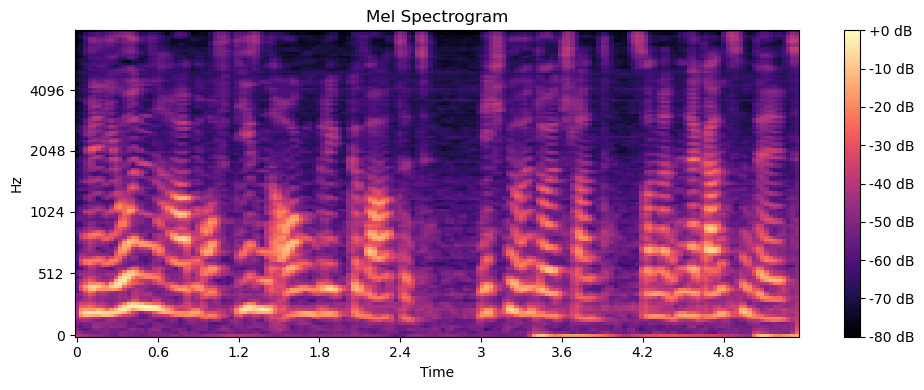

In [29]:
clip_audio = clip.audio
# Create a temporary audio file
with tempfile.NamedTemporaryFile(suffix='.wav') as temp_audio_file:
    clip_audio.write_audiofile(temp_audio_file.name, codec='pcm_s16le')
    
    # Compute Mel Spectrogram using `librosa`

    # Load the audio with librosa
    y, sr = librosa.load(temp_audio_file.name, sr=16000)

    # Compute the mel spectrogram
    S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128, fmax=8000)

    print(S.shape)

    # Convert to dB
    S_dB = librosa.power_to_db(S, ref=np.max)

    # Plot Mel Spectrogram

    plt.figure(figsize=(10, 4))
    librosa.display.specshow(S_dB, x_axis='time', y_axis='mel', sr=sr, fmax=8000)
    plt.colorbar(format='%+2.0f dB')
    plt.title('Mel Spectrogram')
    plt.tight_layout()
    plt.show()

(128, 168)


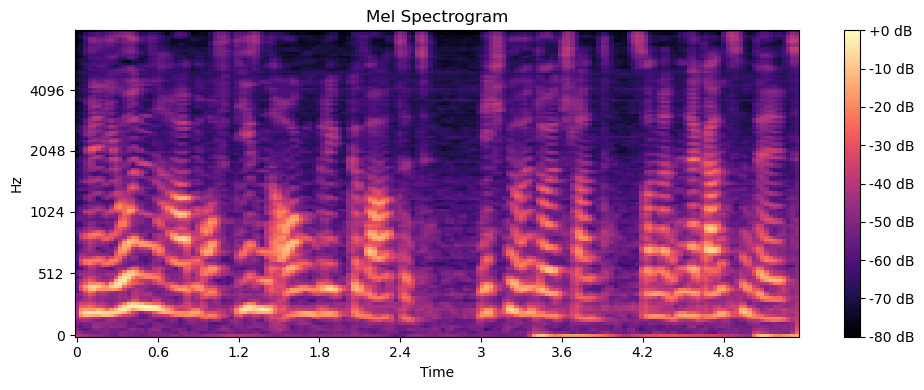

(128, 168)


In [121]:
# Assuming `S` is your computed mel spectrogram
# Downsample the mel spectrogram to match 30 Hz

hop_length = 512  # This is the default in librosa, adjust as needed
original_frame_rate = sr / hop_length

# Calculate the factor to downsample
downsample_factor = int(original_frame_rate / 30)

# Downsample the spectrogram
S_downsampled = S[:, ::downsample_factor]
print(S_downsampled.shape)

# Convert to dB
S_dB = librosa.power_to_db(S_downsampled, ref=np.max)

# Plot Mel Spectrogram

plt.figure(figsize=(10, 4))
librosa.display.specshow(S_dB, x_axis='time', y_axis='mel', sr=sr, fmax=8000)
plt.colorbar(format='%+2.0f dB')
plt.title('Mel Spectrogram')
plt.tight_layout()
plt.show()


print(S_downsampled.shape)
S_linear = librosa.feature.inverse.mel_to_stft(S_downsampled, sr=sr)

# Reconstruct the audio using Griffin-Lim algorithm
y_reconstructed = librosa.griffinlim(S_linear)

# Save the reconstructed audio
sf.write('/tmp/reconstructed_audio.wav', y_reconstructed, sr)
Audio('/tmp/reconstructed_audio.wav')

In [38]:
detector = face_detection.build_detector(
  "RetinaNetResNet50", confidence_threshold=.5, nms_iou_threshold=.3)

/Users/gian/miniconda3/envs/ml/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/gian/miniconda3/envs/ml/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [113]:
T = 90
W, H = 48, 48
spectrogram_frame_rate = sr / 512
print('spectrogram_frame_rate', spectrogram_frame_rate)

X = []
Y = []

for i in range(T):
    # Calculate corresponding spectrogram frame
    spectrogram_frame = int(i * clip.fps / spectrogram_frame_rate)
    print(spectrogram_frame)
    mel_spectrogram_vector = S[:, spectrogram_frame]
    frame = clip.get_frame(i)
    detections = detector.detect(frame)
    bb = detections[0].astype(int)
    cropped_frame = frame[bb[1]:bb[3], bb[0]:bb[2]]
    cropped_frame = cv2.resize(cropped_frame, (W, H))
    X.append(cropped_frame)
    Y.append(mel_spectrogram_vector)

spectrogram_frame_rate 31.25
0
0
1
2
3
4
4
5
6
7
8
8
9
10
11
12
12
13
14
15
16
16
17
18
19
20
20
21
22
23
24
24
25
26
27
28
28
29
30
31
32
32
33
34
35
36
36
37
38
39
40
40
41
42
43
44
44
45
46
47
48
48
49
50
51
52
52
53
54
55
56
56
57
58
59
60
60
61
62
63
64
64
65
66
67
68
68
69
70
71


In [49]:
X2 = torch.Tensor(np.array(X))
X2 = X2.permute(3, 0, 1, 2).unsqueeze(0)  # Reshaping to (1, 3, 5, 48, 48)
print(X2.shape)

torch.Size([1, 3, 90, 48, 48])


In [30]:
# PATH = "/Users/gian/dev/dl4cv/Merkel-Podcast-Corpus/corpus/2006-06-07/video.mp4"
# cap = cv2.VideoCapture(PATH)
# fps = min(FPS, cap.get(cv2.CAP_PROP_FPS))

# duration = cap.get(cv2.CAP_PROP_FRAME_COUNT) / fps

# detector = face_detection.build_detector(
#   "RetinaNetResNet50", confidence_threshold=.5, nms_iou_threshold=.3)

# for i in range(1000):
#     _, frame = cap.read()

# T = 5
# frames = []
# for i in range(T):
#     _, frame = cap.read()
#     frames.append(frame)

Downloading: "https://api.loke.aws.unit.no/dlr-gui-backend-resources-content/v2/contents/links/8dd81669-eb84-4520-8173-dbe49d72f44cb2eef6da-3983-4a12-9085-d11555b93842c19bdf27-b924-4214-9381-e6cac30b87cf" to /Users/gian/.cache/torch/hub/checkpoints/8dd81669-eb84-4520-8173-dbe49d72f44cb2eef6da-3983-4a12-9085-d11555b93842c19bdf27-b924-4214-9381-e6cac30b87cf
100%|██████████| 104M/104M [00:27<00:00, 3.94MB/s] 


In [34]:
# W, H = 48, 48
# cropped_frames = []

# def crop_frames(frames):
#     """
#     Crop frames based on object detections.

#     Args:
#         frames (list): List of input frames.

#     Returns:
#         list: List of cropped frames.
#     """
#     for frame in frames:
#         detections = detector.detect(frame)
#         bb = detections[0].astype(int)
#         cropped_frame = frame[bb[1]:bb[3], bb[0]:bb[2]]
#         cropped_frame = cv2.resize(cropped_frame, (W, H))
#         cropped_frames.append(cropped_frame)

# crop_frames(frames)


In [50]:
X = torch.Tensor(np.array(X))
X = X.permute(3, 0, 1, 2).unsqueeze(0)  # Reshaping to (1, 3, 5, 48, 48)
print(X.shape)

torch.Size([1, 3, 90, 48, 48])


In [114]:
Y = torch.Tensor(np.array(Y))
print(Y.shape)

torch.Size([90, 128])


In [95]:
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride, padding, residual=False):
        super(ConvBlock, self).__init__()
        self.residual = residual
        self.conv = nn.Conv3d(in_channels, out_channels, kernel_size=kernel_size, stride=stride, padding=padding)
        self.batch_norm = nn.BatchNorm3d(out_channels)
        self.activation = nn.ReLU()

    def forward(self, x):
        pre_x = x

        x = self.conv(x)
        x = self.batch_norm(x)
        x = self.activation(x)

        if self.residual:
            x += pre_x
        return x

def calculate_padding(kernel_size, stride):
    return [
            (kernel_size - stride[0]) // 2,  # Padding for depth dimension
            (kernel_size - stride[1]) // 2,  # Padding for height dimension
            (kernel_size - stride[2]) // 2   # Padding for width dimension
        ]

class LipEncoder(nn.Module):
    def __init__(self):
        super(LipEncoder, self).__init__()
        self.blocks = []
        NUM_BLOCKS = 4
        c = 3
        for i in range(NUM_BLOCKS):
            kernel_size = (5 if i == 0 else 3)
            stride = (1, 2, 2)  # Stride
            padding = calculate_padding(kernel_size, stride)
            block = ConvBlock((c if i == 0 else c//2), c, kernel_size, stride, padding)
            self.blocks.append(block)

            for j in range(2):
                kernel_size = 3
                stride = (1, 1, 1)
                padding = calculate_padding(kernel_size, stride)

                block1 = ConvBlock(c, c, kernel_size, (1, 1, 1), padding, residual=True)
                block2 = ConvBlock(c, c, kernel_size, (1, 1, 1), padding, residual=True)

                self.blocks.append(block1)
                self.blocks.append(block2)

            if i == NUM_BLOCKS - 1:
                stride = (1, 3, 3)
                padding = calculate_padding(kernel_size, stride)

                last_block = ConvBlock(c, c, kernel_size=(1, 2, 2), stride=1, padding=0)
                self.blocks.append(last_block)

            c *= 2
        self.seq = nn.Sequential(*self.blocks)

    def forward(self, x):
        x = self.seq(x)

        #print('x', x.shape)
        x = x.squeeze(-1).squeeze(-1)
        #print('x after squeeze', x.shape)
        x = x.view(-1, T, 24)
        #print(x.shape)
        return x

In [102]:
class LipDecoder(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_dim):
        super(LipDecoder, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        # Bi-directional LSTM layer
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, bidirectional=True)

        # Fully connected layer to transform the output dimension
        self.fc = nn.Linear(hidden_size * 2, output_dim)  # Multiply hidden_size by 2 for bi-directional

    def forward(self, x):
        # Set initial states
        h0 = torch.zeros(self.num_layers * 2, x.size(0), self.hidden_size)  # 2 for bidirectional
        c0 = torch.zeros(self.num_layers * 2, x.size(0), self.hidden_size)

        # Forward propagate the LSTM
        out, _ = self.lstm(x, (h0, c0))  # out: tensor of shape (batch_size, seq_length, hidden_size * 2)

        # Transform to output dimension at each time step
        out = self.fc(out)

        return out

In [103]:
encoder = LipEncoder()
decoder = LipDecoder(24, 128, 2, 128)
#summary(encoder, input_size=(1, 3, T, 48, 48))
y = encoder(X)
print(y.shape)

y = decoder(y)
print(y.shape)

x torch.Size([1, 24, 90, 1, 1])
x after squeeze torch.Size([1, 24, 90])
torch.Size([1, 90, 24])
torch.Size([1, 90, 24])
torch.Size([1, 90, 128])


In [115]:
print(Y.shape)

torch.Size([90, 128])


In [133]:
# Reconstruct the audio using Griffin-Lim algorithm

# Define the parameters used to create the Mel spectrogram
n_fft = 2048  # Number of FFT components; adjust based on how you computed the Mel spectrogram
hop_length = 512  # Hop length; adjust accordingly
n_mels = 128  # Number of Mel bands
sr = 16000

# Convert the tensor to numpy for processing with librosa
Y_np = Y.transpose(1, 0).numpy()
print(Y_np.shape)
print(Y_np.shape[-2])

# Convert Mel spectrogram to STFT
linear_segment = librosa.feature.inverse.mel_to_stft(Y_np, sr=sr, n_fft=n_fft)

# Griffin-Lim reconstruction
audio_griffin = librosa.griffinlim(linear_segment, n_iter=32, hop_length=hop_length)  # Adjust n_iter as needed

# Save to WAV file
sf.write('/tmp/output.wav', audio_griffin, sr)
Audio('/tmp/output.wav')

(128, 90)
128
